In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 383 kB/s 


Primero Importamos las librerias que vamos a utilizar

In [ ]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import collections

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_columns", 1000)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Grupo_3_Data_Science/4to Bimestre/weatherAUS.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Se trabajara con un Dataset con los datos de las lluvias de Australia. 
Se construye un escenario en el cual una Empresa organizadora de eventos(Casamientos y Cumpleaños) al airea libre debe decidir entre contratar o no una carpa. Esto implica un mayor costo, el cual no es trasladable,.  

1.   Si contrata la Carpa y llueve, el evento es un exito
2.   Si no contrata la carpa y no llueve, el evento es un exito
3.   Si no contrata la carpa y llueve, debe realizar una   devolucion del Dinero de x%
4.   Mientras que si contrata la carpa y No llueve, debe realizar una (x-a)% de devolucion, por cuanto las condiciones originales de contratacion eran al aire Libre  

Valores a tener en cuenta 

1.   Ingreso Por evento = 200.000
2.   Costo de Carpa = 50.000 
3.   Cancelacion por Lluvia = 180.000
4.   Devolucion por evento Cerrado  =  45.000
5.   Costo fijo por evento = 60.000



Cabe destacar que no se tiene en cuenta el costo reputacional de suspender el evento 








En Primer lugar se Dropearon aquellas filas en donde no existían datos sobre las lluvias

In [ ]:
cleanable_df = df
cleanable_df = cleanable_df.dropna(subset=["RainToday","RainTomorrow"])

Comenzamos con la Limpieza del dataset, 
Se cambian las columnas a Date,y se eliminan los datos previos al 2009
Calculamos columnas auxiliares para 
Locacion, Mes y Season 

In [ ]:
date_df = cleanable_df
date_df["Date"] = pd.to_datetime(date_df['Date'])
date_df = date_df[date_df["Date"].dt.year >= 2009]
date_df['Week_Number'] = date_df['Date'].dt.week
date_df["Month_Number"] = date_df['Date'].dt.month
date_df["Season_Number"] = (date_df["Date"].dt.month%12 + 3)//3
date_df["Week_Place"] = date_df['Week_Number'].apply(str) + " - " + date_df["Location"]
date_df["Month_Place"] = date_df['Month_Number'].apply(str) + " - " + date_df["Location"]
date_df["Season_Place"] = date_df['Season_Number'].apply(str) + " - " + date_df["Location"]
#print(date_df.loc[[284]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3

In [ ]:
cols_to_avg = ["MinTemp","MaxTemp","Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","Temp9am","Temp3pm","Evaporation","Sunshine","Cloud9am","Cloud3pm"]
for col in cols_to_avg:
  date_df[col] = df[col].fillna(date_df.groupby("Week_Place")[col].transform('mean').round(2))
  date_df[col] = df[col].fillna(date_df.groupby("Month_Place")[col].transform('mean').round(2))
  date_df[col] = df[col].fillna(date_df.groupby("Season_Place")[col].transform('mean').round(2))

print(date_df.info())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138497 entries, 31 to 145458
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           138497 non-null  datetime64[ns]
 1   Location       138497 non-null  object        
 2   MinTemp        138497 non-null  float64       
 3   MaxTemp        138497 non-null  float64       
 4   Rainfall       138497 non-null  float64       
 5   Evaporation    94407 non-null   float64       
 6   Sunshine       87340 non-null   float64       
 7   WindGustDir    129780 non-null  object        
 8   WindGustSpeed  132634 non-null  float64       
 9   WindDir9am     128925 non-null  object        
 10  WindDir3pm     134846 non-null  object        
 11  WindSpeed9am   138497 non-null  float64       
 12  WindSpeed3pm   138497 non-null  float64       
 13  Humidity9am    138497 non-null  float64       
 14  Humidity3pm    138497 non-null  float64       
 15 

Reemplazamos los nulos por las medianas , y dropeamos los NA

In [ ]:
date_df["Evaporation"].fillna((date_df["Evaporation"].median()), inplace=True)
date_df["Sunshine"].fillna((date_df["Sunshine"].median()), inplace=True)
date_df["Cloud9am"].fillna((date_df["Cloud9am"].median()), inplace=True)
date_df["Cloud3pm"].fillna((date_df["Cloud3pm"].median()), inplace=True)
date_df["Pressure9am"].fillna(1013.14, inplace=True)
date_df["Pressure3pm"].fillna(1013.14, inplace=True)
date_df = date_df.dropna()
date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121928 entries, 31 to 145458
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           121928 non-null  datetime64[ns]
 1   Location       121928 non-null  object        
 2   MinTemp        121928 non-null  float64       
 3   MaxTemp        121928 non-null  float64       
 4   Rainfall       121928 non-null  float64       
 5   Evaporation    121928 non-null  float64       
 6   Sunshine       121928 non-null  float64       
 7   WindGustDir    121928 non-null  object        
 8   WindGustSpeed  121928 non-null  float64       
 9   WindDir9am     121928 non-null  object        
 10  WindDir3pm     121928 non-null  object        
 11  WindSpeed9am   121928 non-null  float64       
 12  WindSpeed3pm   121928 non-null  float64       
 13  Humidity9am    121928 non-null  float64       
 14  Humidity3pm    121928 non-null  float64       
 15 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
date_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Week_Number', 'Month_Number',
       'Season_Number', 'Week_Place', 'Month_Place', 'Season_Place'],
      dtype='object')

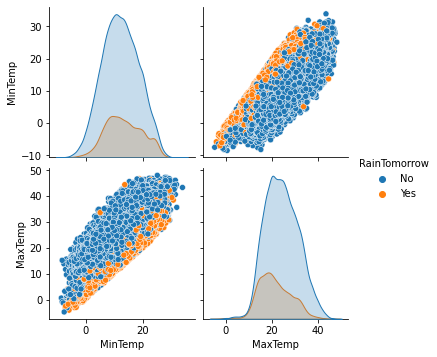

In [ ]:
sns.pairplot(date_df.drop(columns=['Date', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Week_Number', 'Month_Number',
       'Season_Number', 'Week_Place', 'Month_Place', 'Season_Place']), hue='RainTomorrow')

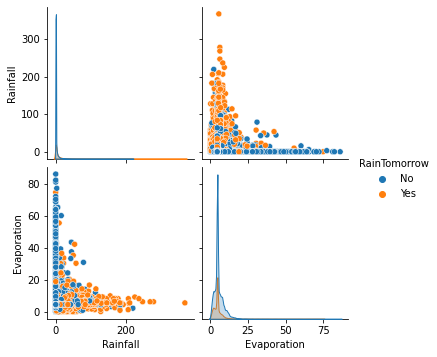

In [ ]:
sns.pairplot(date_df.drop(columns=['Date', 'MinTemp', 'MaxTemp',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Week_Number', 'Month_Number',
       'Season_Number', 'Week_Place', 'Month_Place', 'Season_Place']), hue='RainTomorrow')

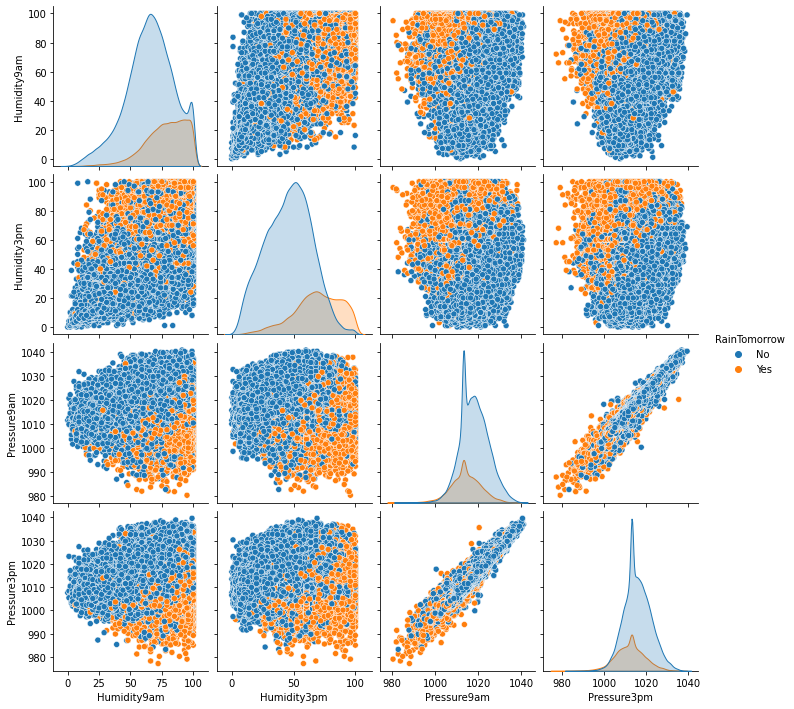

In [ ]:
sns.pairplot(date_df.drop(columns=['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Week_Number', 'Month_Number',
       'Season_Number', 'Week_Place', 'Month_Place', 'Season_Place']), hue='RainTomorrow')

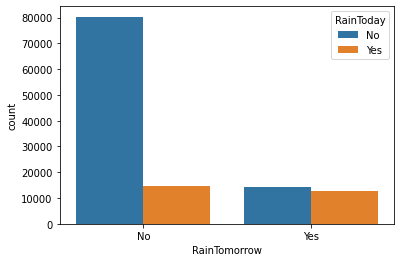

In [ ]:
sns.countplot(x='RainTomorrow',hue='RainToday',data=date_df)

In [ ]:
date_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Week_Number,Month_Number,Season_Number,Week_Place,Month_Place,Season_Place
31,2009-01-01,Albury,11.3,26.5,0.0,4.6,8.18,WNW,56.0,W,WNW,19.0,31.0,46.0,26.0,1004.5,1003.2,5.65,4.86,19.7,25.7,No,No,1,1,1,1 - Albury,1 - Albury,1 - Albury
32,2009-01-02,Albury,9.6,23.9,0.0,4.6,8.18,W,41.0,WSW,SSW,19.0,11.0,44.0,22.0,1014.4,1013.1,5.65,4.86,14.9,22.1,No,No,1,1,1,1 - Albury,1 - Albury,1 - Albury
33,2009-01-03,Albury,10.5,28.8,0.0,4.6,8.18,SSE,26.0,SSE,E,11.0,7.0,43.0,22.0,1018.7,1014.8,5.65,4.86,17.1,26.5,No,No,1,1,1,1 - Albury,1 - Albury,1 - Albury
34,2009-01-04,Albury,12.3,34.6,0.0,4.6,8.18,WNW,37.0,SSE,NW,6.0,17.0,41.0,12.0,1015.1,1010.3,5.65,4.86,20.7,33.9,No,No,1,1,1,1 - Albury,1 - Albury,1 - Albury
35,2009-01-05,Albury,12.9,35.8,0.0,4.6,8.18,WNW,41.0,ENE,NW,6.0,26.0,41.0,9.0,1012.6,1009.2,5.65,4.86,22.4,34.4,No,No,2,1,1,2 - Albury,1 - Albury,1 - Albury


Una vez que tenemos reemplazados los Nan, utilizamos one hot para desagregar los categoricos y los Joineamos con el dataset original. Desagregar los categoricos, es decir, no otorgar mas peso a ninguna categoria, creando una columna por cada categoria. De ese modo ninguna categoria posee un valor mayor que la otra. 

In [ ]:

enc = OneHotEncoder(sparse=False,drop=None,categories='auto', handle_unknown='error')
oh_df = date_df.drop(columns=["Week_Number","Season_Number","Week_Place","Month_Place","Season_Place","Date"])
oh_df['Month_Number'] = oh_df['Month_Number'].astype(str)


# passing bridge-types-cat column (label encoded values of bridge_types)
oh_location = pd.DataFrame(enc.fit_transform(oh_df[['Location']]), columns=enc.categories_)
oh_wind_dir = pd.DataFrame(enc.fit_transform(oh_df[['WindGustDir']]), columns=enc.categories_)
oh_wind_dir_9 = pd.DataFrame(enc.fit_transform(oh_df[['WindDir9am']]), columns=enc.categories_)
oh_wind_dir_3 = pd.DataFrame(enc.fit_transform(oh_df[['WindDir3pm']]), columns=enc.categories_)
oh_Month_num = pd.DataFrame(enc.fit_transform(oh_df[["Month_Number"]]), columns=enc.categories_)

# merge with main df bridge_df on key values
oh_df = oh_df.merge(oh_location, left_index=True, right_index=True )
oh_df = oh_df.merge(oh_wind_dir, left_index=True, right_index=True )
oh_df = oh_df.merge(oh_wind_dir_9, left_index=True, right_index=True)
oh_df = oh_df.merge(oh_wind_dir_3, left_index=True, right_index=True)
oh_df = oh_df.merge(oh_Month_num, left_index=True, right_index=True)


oh_df.drop(columns=['Location','WindGustDir','WindDir9am','WindDir3pm','Month_Number'], inplace = True)
oh_df.reset_index(inplace=True)

oh_df.rename(columns=''.join, inplace=True)
oh_df.columns = oh_df.columns.str.replace(r"[('',)]", "")





In [ ]:
oh_df.head()

,index,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,E_x,ENE_x,ESE_x,N_x,NE_x,NNE_x,NNW_x,NW_x,S_x,SE_x,SSE_x,SSW_x,SW_x,W_x,WNW_x,WSW_x,E_y,ENE_y,ESE_y,N_y,NE_y,NNE_y,NNW_y,NW_y,S_y,SE_y,SSE_y,SSW_y,SW_y,W_y,WNW_y,WSW_y,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,1,10,11,12,2,3,4,5,6,7,8,9
0,31,11.3,26.5,0.0,4.6,8.18,56.0,19.0,31.0,46.0,26.0,1004.5,1003.2,5.65,4.86,19.7,25.7,No,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,9.6,23.9,0.0,4.6,8.18,41.0,19.0,11.0,44.0,22.0,1014.4,1013.1,5.65,4.86,14.9,22.1,No,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33,10.5,28.8,0.0,4.6,8.18,26.0,11.0,7.0,43.0,22.0,1018.7,1014.8,5.65,4.86,17.1,26.5,No,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34,12.3,34.6,0.0,4.6,8.18,37.0,6.0,17.0,41.0,12.0,1015.1,1010.3,5.65,4.86,20.7,33.9,No,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35,12.9,35.8,0.0,4.6,8.18,41.0,6.0,26.0,41.0,9.0,1012.6,1009.2,5.65,4.86,22.4,34.4,No,No,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Utilizamos ordinal encoder para aquellas columnas cuyas categorias son consideradas incrementales es decir, que una categoria vale mas que la otra. Por ejemplo una columna de YES/NO se le asigna:



*   YES = 1
*   NO = 0





In [ ]:
ordinal_df = oh_df

encoder= ce.OrdinalEncoder(
    handle_unknown= "error",
    mapping=[
             {'col':'RainToday',
              'mapping':{
                  'Yes': 1,
                  'No': 0, 
                  }
             },
             {'col':'RainTomorrow',
              'mapping':{
                  'Yes': 1,
                  'No': 0, 
                  }
             },
])


ordinal_df = encoder.fit_transform(ordinal_df)
ordinal_df = ordinal_df.fillna(0)

In [ ]:
ordinal_df.head()

,index,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Adelaide,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,E_x,ENE_x,ESE_x,N_x,NE_x,NNE_x,NNW_x,NW_x,S_x,SE_x,SSE_x,SSW_x,SW_x,W_x,WNW_x,WSW_x,E_y,ENE_y,ESE_y,N_y,NE_y,NNE_y,NNW_y,NW_y,S_y,SE_y,SSE_y,SSW_y,SW_y,W_y,WNW_y,WSW_y,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,1,10,11,12,2,3,4,5,6,7,8,9
0,31,11.3,26.5,0.0,4.6,8.18,56.0,19.0,31.0,46.0,26.0,1004.5,1003.2,5.65,4.86,19.7,25.7,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,9.6,23.9,0.0,4.6,8.18,41.0,19.0,11.0,44.0,22.0,1014.4,1013.1,5.65,4.86,14.9,22.1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33,10.5,28.8,0.0,4.6,8.18,26.0,11.0,7.0,43.0,22.0,1018.7,1014.8,5.65,4.86,17.1,26.5,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34,12.3,34.6,0.0,4.6,8.18,37.0,6.0,17.0,41.0,12.0,1015.1,1010.3,5.65,4.86,20.7,33.9,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35,12.9,35.8,0.0,4.6,8.18,41.0,6.0,26.0,41.0,9.0,1012.6,1009.2,5.65,4.86,22.4,34.4,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(ordinal_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100747 entries, 0 to 100746
Columns: 126 entries, index to 9
dtypes: float64(123), int64(3)
memory usage: 96.8 MB
None


Preparamos el dataset para test y train. Se le asigna un 80% a train y 20% a test. ¿Por que? La creacion de un modelo consiste en dos faces, una de entrenamiento, a la cual se le asigna el 80% de los datos disponibles y la siguiente de testeo o prueba que permite verificar el funcionamiento con el 20% restante.

In [ ]:
features =list(ordinal_df.drop(columns=["RainTomorrow"]).columns)

X = ordinal_df[features]
y = ordinal_df["RainTomorrow"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=0)
X_train.shape, X_test.shape

((80597, 125), (20150, 125))

*Modelo 1 RANDOM FOREST*

In [ ]:
cv = StratifiedKFold(n_splits=5)
#Best for recall: {0:45,1:210}
#Best for balanced precision and recall: {0:25,1:50}
param_grid = {
          'n_estimators':[100] # default 100 
          ,'max_depth':[7] # default None 
          ,'criterion': ['entropy'] # default 'gini'
          ,'min_samples_leaf': [1] # default 1
          ,'random_state' : [42]
          ,'class_weight': [{0:45,1:210}]#[{0:45,1:210},{0:25,1:50},]
          }

score_list = ['accuracy','precision','recall','roc_auc','f1']
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv, verbose=3, scoring='precision', refit = 'precision')

In [ ]:
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.get_params())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight={0: 45, 1: 210}, criterion=entropy, max_depth=7, min_samples_leaf=1, n_estimators=100, random_state=42;, score=0.449 total time=   6.9s
[CV 2/5] END class_weight={0: 45, 1: 210}, criterion=entropy, max_depth=7, min_samples_leaf=1, n_estimators=100, random_state=42;, score=0.454 total time=   6.8s
[CV 3/5] END class_weight={0: 45, 1: 210}, criterion=entropy, max_depth=7, min_samples_leaf=1, n_estimators=100, random_state=42;, score=0.440 total time=   6.8s
[CV 4/5] END class_weight={0: 45, 1: 210}, criterion=entropy, max_depth=7, min_samples_leaf=1, n_estimators=100, random_state=42;, score=0.450 total time=   6.9s
[CV 5/5] END class_weight={0: 45, 1: 210}, criterion=entropy, max_depth=7, min_samples_leaf=1, n_estimators=100, random_state=42;, score=0.449 total time=   6.8s
{'class_weight': {0: 45, 1: 210}, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state

*Se analizan las Predicciones* 

In [ ]:
# Predict on training set and test set
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print('Accuracy')
train_accuracy= accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Train:',train_accuracy)
print('Test:',test_accuracy)
print(' ')
print('Recall')
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
print('Train:', train_recall)
print('Test:', test_recall)
print(' ')
print('Precision')
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
print('Train:', train_precision)
print('Test:', test_precision)

Accuracy
Train: 0.7369505068426865
Test: 0.7280397022332507
 
Recall
Train: 0.8475353669319187
Test: 0.8398164335664335
 
Precision
Train: 0.45403949199206606
Test: 0.44738067520372526


Precision -> De todos los que dijo que iban a ser lluvia, cuantos lo son efectivamente.

Recall -> De todo lo que es lluvia (Real), cuantos dijo mi modelo que iban a serlo.

F1-score -> La media armonica entre presicion y recall

Support -> El numero de ocurrencias de cada clase en y_true

In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     15574
           1       0.45      0.84      0.58      4576

    accuracy                           0.73     20150
   macro avg       0.69      0.77      0.69     20150
weighted avg       0.83      0.73      0.75     20150




     TN | FP  
     -------
     FN | TP


1.   TN = True Negative
2.   FN = False Negative
3.   FP = False Positive
4.   TP = True positive

Positive = Llueve
Negative = No llueve

True = Coincidencia (ejemplo = Llueve y efectivamente llueve)
False = Discrepancia (ejemplo = Llueve, pero no llovio)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


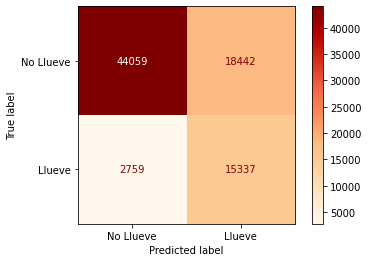

In [ ]:
#confusion_matrix(y_train, y_train_pred)

plot_confusion_matrix(grid, X_train, y_train, display_labels=["No Llueve","Llueve"], cmap = "OrRd")  
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


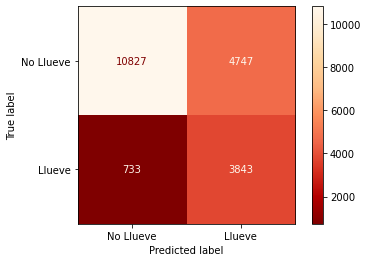

In [ ]:
#confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(grid, X_test, y_test, display_labels=["No Llueve","Llueve"], cmap = "OrRd_r")  
plt.show()

Curva ROC -> Nos indica el corte. El mejor corte es aquel que posee la mayor cantidad de true positives rate en conjuncion con false postive rate mas bajo. Por debajo de la linea, se nos indican los true postives, por debajo los false positives. 

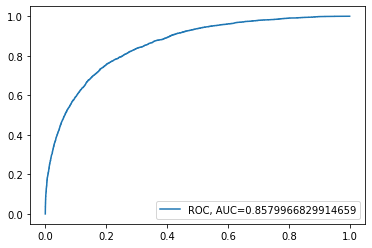

In [ ]:
y_pred_proba = grid.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

**Modelo 2 Logistic**

In [ ]:
cv = StratifiedKFold(n_splits=5)
param_grid_log = {

          }
grid_log = GridSearchCV(LogisticRegression(), param_grid=param_grid_log, cv=cv, verbose=3, scoring='roc_auc')

In [ ]:
grid_log.fit(X_train, y_train)
print(grid_log.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/5] END ..................................., score=0.857 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/5] END ..................................., score=0.854 total time=   3.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/5] END ..................................., score=0.853 total time=   3.0s
[CV 4/5] END ..................................., score=0.844 total time=   1.4s
[CV 5/5] END ..................................., score=0.854 total time=   3.0s
{}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# Predict on training set and test set
y_train_pred_log = grid_log.predict(X_train)
y_test_pred_log = grid_log.predict(X_test)

print('Accuracy')
train_accuracy_log= accuracy_score(y_train, y_train_pred_log)
test_accuracy_log = accuracy_score(y_test, y_test_pred_log)
print('Train:',train_accuracy)
print('Test:',test_accuracy)
print(' ')
print('Recall')
train_recall_log = recall_score(y_train, y_train_pred_log)
test_recall_log = recall_score(y_test, y_test_pred_log)
print('Train:', train_recall)
print('Test:', test_recall)
print(' ')
print('Precision')
train_precision_log = precision_score(y_train, y_train_pred_log)
test_precision_log = precision_score(y_test, y_test_pred_log)
print('Train:', train_precision)
print('Test:', test_precision)

Accuracy
Train: 0.7369505068426865
Test: 0.7280397022332507
 
Recall
Train: 0.8475353669319187
Test: 0.8398164335664335
 
Precision
Train: 0.45403949199206606
Test: 0.44738067520372526


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


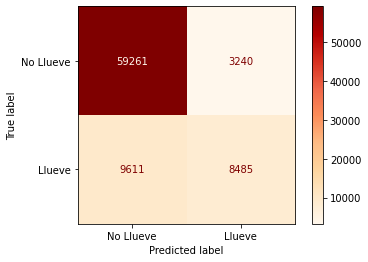

In [ ]:
#confusion_matrix(y_train, y_train_pred)

plot_confusion_matrix(grid_log, X_train, y_train,display_labels=["No Llueve","Llueve"], cmap = "OrRd")  
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


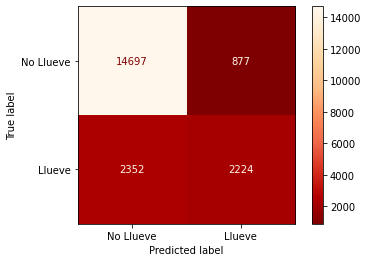

In [ ]:
#confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(grid_log, X_test, y_test,display_labels=["No Llueve","Llueve"] ,cmap = "OrRd_r")  
plt.show()

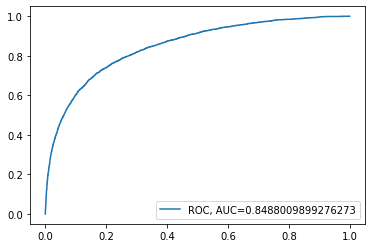

In [ ]:
y_pred_proba_log = grid_log.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_log)
auc = roc_auc_score(y_test, y_pred_proba_log)
plt.plot(fpr,tpr,label="ROC, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
pred=dtree.predict(X_test)

In [ ]:
print(classification_report(y_test,pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     15574
           1       0.53      0.55      0.54      4576

    accuracy                           0.79     20150
   macro avg       0.70      0.70      0.70     20150
weighted avg       0.79      0.79      0.79     20150



array([[13341,  2233],
       [ 2062,  2514]])

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     15574
           1       0.53      0.55      0.54      4576

    accuracy                           0.79     20150
   macro avg       0.70      0.70      0.70     20150
weighted avg       0.79      0.79      0.79     20150



Luego de haber evaluado los distintos modelos , se concluye que el mas eficiente dada la estructura de datos es el Random Forest.
A partir de esto se Correra una simulación teniendo en cuenta los datos de la firma a fin de estimar cual es el desvío esperado de los ingresos 

En funcion del clima predicho por el modelo :
Llueve // No llueve.
Se realiza una estimación de los beneficios, dados los costos e ingresos detallados 
 

Valores a tener en cuenta 

1.   Ingreso Por evento = 200.000
2.   Costo de Carpa = 50.000 
3.   Cancelacion por Lluvia = 180.000
4.   Devolucion por evento a cielo Cerrado  = 45.000
5.   Costo fijo por evento = 60.000

Una vez hecha la estimación se obtiene un nuevo dataset  
el cual se detallan los Beneficios Esperados y los Beneficios Percibidos.

*   Se calcula el % de los devios respecto del beneficio Percibido respecto al Proyectado 
*   A partir de simular 3000 veces con una muestra aleatoria de 1000 registros, se obtiene la mediana de los de los Desvios




In [ ]:
i = 0
deviation = []
for i in range(3000):
  print("Iteracion: ", i)
  marriage_df = X_test.sample(n=1000)
  marriage_pred = grid.predict(marriage_df)
  #marriage_pred = marriage_pred.rename(columns={0: "Prediction"})

  #Creamos un df con todos los datos
  profit_df = marriage_df
  profit_df["Prediction"] = marriage_pred.tolist()

  #Creamos una columna de Ingresos estimados por evento
  profit_df["Pred Income"] = 200000
  profit_df["Fixed Cost"] = 60000 #Costo fijo por organizar el evento
  profit_df["Pred Variable Cost"] = np.where(profit_df['Prediction']==1, 50000, 0) # Costo de la carpa

  #Calculamos el Profit estimado
  profit_df["Pred Profit"] = profit_df["Pred Income"] - profit_df["Fixed Cost"] - profit_df["Pred Variable Cost"]

  #Agregamos el resultado real sobre la lluvia
  real_df = pd.DataFrame(y)
  profit_df = profit_df.merge(real_df, left_index=True, right_index = True, how = 'inner')

  #Analizamos para calcular profit real
  profit_df["Insurance"] = np.where(profit_df['Prediction']== profit_df['RainTomorrow'], 0, 
                                  np.where(profit_df['Prediction'] >  profit_df['RainTomorrow'], 45000,
                                        180000   )
                                  )

  profit_df["Real Profit"] = profit_df["Pred Profit"] - profit_df["Insurance"]
  profit_df["Profit Dif $"] = profit_df["Pred Profit"] - profit_df["Real Profit"]

  final_df = profit_df[["Prediction","RainTomorrow","Pred Income","Fixed Cost","Pred Variable Cost","Pred Profit","Insurance","Real Profit","Profit Dif $"]]

  print("Desvío de lo proyectado %: ", (final_df["Profit Dif $"].sum() / profit_df["Pred Profit"].sum()).round(2))
  print("Desvío de lo proyectado $: ", final_df["Profit Dif $"].sum())
  deviation.append((final_df["Profit Dif $"].sum() / profit_df["Pred Profit"].sum()).round(2))






Streaming output truncated to the last 5000 lines.
Desvío de lo proyectado %:  0.16
Desvío de lo proyectado $:  18450000
Iteracion:  1334
Desvío de lo proyectado %:  0.14
Desvío de lo proyectado $:  17010000
Iteracion:  1335
Desvío de lo proyectado %:  0.15
Desvío de lo proyectado $:  17550000
Iteracion:  1336
Desvío de lo proyectado %:  0.15
Desvío de lo proyectado $:  18000000
Iteracion:  1337
Desvío de lo proyectado %:  0.13
Desvío de lo proyectado $:  15750000
Iteracion:  1338
Desvío de lo proyectado %:  0.15
Desvío de lo proyectado $:  17370000
Iteracion:  1339
Desvío de lo proyectado %:  0.13
Desvío de lo proyectado $:  14895000
Iteracion:  1340
Desvío de lo proyectado %:  0.14
Desvío de lo proyectado $:  16740000
Iteracion:  1341
Desvío de lo proyectado %:  0.16
Desvío de lo proyectado $:  18360000
Iteracion:  1342
Desvío de lo proyectado %:  0.14
Desvío de lo proyectado $:  17100000
Iteracion:  1343
Desvío de lo proyectado %:  0.14
Desvío de lo proyectado $:  16920000
Iteracion

In [ ]:
deviation_median = np.median(deviation)
print(deviation_median)

0.14


In [ ]:
deviation


In [ ]:
df = pd.DataFrame(deviation_counts, index=[0])

df

,0.13,0.15,0.16,0.14,0.12,0.11,0.17,0.18
0,454,1001,331,1097,52,4,57,4


In [ ]:
df = df.T


In [ ]:
df

,0
0.13,454
0.15,1001
0.16,331
0.14,1097
0.12,52
0.11,4
0.17,57
0.18,4


In [ ]:
df.reset_index(inplace = True)
df

,index,0
0,0.13,454
1,0.15,1001
2,0.16,331
3,0.14,1097
4,0.12,52
5,0.11,4
6,0.17,57
7,0.18,4


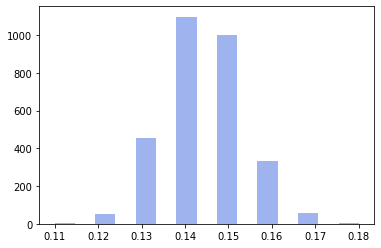

In [134]:
num_bins = 15
n, bins, patches = plt.hist(deviation, num_bins, facecolor='royalblue', alpha=0.5)
plt.show()